# Regression
Written by W.-H. Shin\
Aug. 2 2025\
Modified from Pat Walter's example.\
In this tutorial, a machine learning model that predicts molecule solubility using LightGBM will be generated.

## Installing softwares and modules

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

!conda install pandas seaborn numpy rdkit PyTDC scikit-learn yellowbrick
!pip install lightgbm

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - numpy
    - pandas
    - pytdc
    - rdkit
    - scikit-learn
    - seaborn
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.1.0               |       hb9d3cd8_2          19 KB  conda-forge
    brotli-bin-1.1.0           |       hb9d3cd8_2          18 KB  conda-forge
    ca-certificates-2025.7.14  |       hbd8a1cb_0         152 KB  conda-forge
    cairo-1.18.4               |       h3394656_0         955 KB  conda-forge
    certifi-2025.7.1

In [1]:
from tqdm.auto import tqdm #progress bar
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
import numpy as np #matrix algebra
from lightgbm import LGBMRegressor, plot_importance #LightGBM models
from sklearn.model_selection import train_test_split #ML training
from sklearn.metrics import r2_score, mean_squared_error #ML stats
import seaborn as sns #Plotting
from yellowbrick.regressor import prediction_error, ResidualsPlot
from tdc.single_pred import ADME
from rdkit.rdBase import BlockLogs

Set parameters for tqdm and seaborn

In [2]:
sns.set_context('talk')
tqdm.pandas()

## Reading data and calculate properties
Reference: https://pubs.acs.org/doi/10.1021/ci034243x

In [3]:
data = ADME(name = 'Solubility_AqSolDB')
sol_df = data.get_data()
sol_df.columns = ["Name","SMILES","LogS"]

Downloading...
100%|██████████| 853k/853k [00:00<00:00, 4.70MiB/s]
Loading...
Done!


Setup property calculations

In [4]:
property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
property_getter = rdMolDescriptors.Properties(property_names)

Define a function to calculate properties from SMILES string

In [5]:
def smi2props(smi):
    mol = Chem.MolFromSmiles(smi)
    props = None
    if mol:
        Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        props = np.array(property_getter.ComputeProperties(mol))
    return props

Add the calculated properties to the table

In [6]:
block = BlockLogs() # To remove long logs
sol_df['props'] = sol_df.SMILES.progress_apply(smi2props)
del block

  0%|          | 0/9982 [00:00<?, ?it/s]

Put the descriptors into new columns

In [7]:
sol_df = sol_df[sol_df['props'].notna()]
sol_df[property_names] = sol_df['props'].to_list()
sol_df

,Name,SMILES,LogS,props,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127,"[391.28136257200003, 392.50999999999993, 1.0, ...",391.281363,392.510,1.0,0.0,17.0,0.0,...,16.845993,10.364975,4.682488,4.682488,3.134242,0.440000,25.677560,18.774017,24.808021,20.959606
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767,"[169.052763844, 169.18299999999996, 2.0, 1.0, ...",169.052764,169.183,2.0,1.0,0.0,1.0,...,6.872350,4.192158,2.397526,2.397526,1.824022,-1.830000,6.660756,2.102073,0.745786,1.077031
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078,"[140.00289246, 140.569, 1.0, 0.0, 1.0, 0.0, 1....",140.002892,140.569,1.0,0.0,1.0,0.0,...,4.672964,2.534727,1.006088,1.006088,0.541348,-0.820000,6.302249,2.646097,1.541347,1.852930
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409,"[754.227281264, 756.2260000000001, 6.0, 2.0, 1...",754.227281,756.226,6.0,2.0,10.0,2.0,...,30.400335,17.334648,9.894590,9.894590,6.542454,-5.516623,40.256883,18.303167,9.483471,13.902423
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065,"[422.22055743999994, 422.52500000000026, 6.0, ...",422.220557,422.525,6.0,0.0,12.0,0.0,...,17.819585,11.425462,6.316788,6.316788,4.132685,-2.120000,19.556716,8.431191,5.573965,5.318916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000,"[264.183778008, 264.3689999999999, 4.0, 1.0, 8...",264.183778,264.369,4.0,1.0,8.0,1.0,...,12.108645,6.789606,2.751714,2.751714,1.537913,-1.550000,15.507307,8.534307,6.246200,6.965480
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930000,"[444.15326572799995, 444.44000000000017, 10.0,...",444.153266,444.440,10.0,7.0,2.0,6.0,...,17.656585,9.970255,7.022223,7.022223,5.508747,-3.210000,22.000761,6.644027,2.478484,4.567926
9979,thymol,Cc1ccc(C(C)C)c(O)c1,-2.190000,"[150.104465068, 150.221, 1.0, 1.0, 1.0, 1.0, 1...",150.104465,150.221,1.0,1.0,1.0,1.0,...,7.256615,3.905016,1.807947,1.807947,1.141920,-0.980000,8.119800,2.951612,1.732031,2.178773
9980,verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.980000,"[454.28315769599993, 454.6110000000002, 6.0, 0...",454.283158,454.611,6.0,0.0,13.0,0.0,...,21.104406,11.379316,6.424875,6.424875,4.225327,-2.910000,26.343179,12.362156,6.326434,9.868439


## Split data and gererate a model
In order to build a model, we need to split the data into training and test. Train_test_split function of scikit-learn puts 80% to training and 20% to test sets by default.

In [8]:
train, test = train_test_split(sol_df)

Set X and Y values stored in the Pandas dataframe.

In [9]:
train_X = train[property_names]
train_Y = train.LogS
test_X = test[property_names]
test_Y = test.LogS

Create LightGBM regressor

In [10]:
lgbm = LGBMRegressor()

Train the model

In [11]:
lgbm.fit(train_X,train_Y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6076
[LightGBM] [Info] Number of data points in the train set: 7485, number of used features: 43
[LightGBM] [Info] Start training from score -2.877809


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Do prediction on the test set

In [12]:
pred = lgbm.predict(test_X)

Plot the predicted LogS and real LogS values as a scatter plot

[Text(0, 0.5, 'Predicted LogS')]

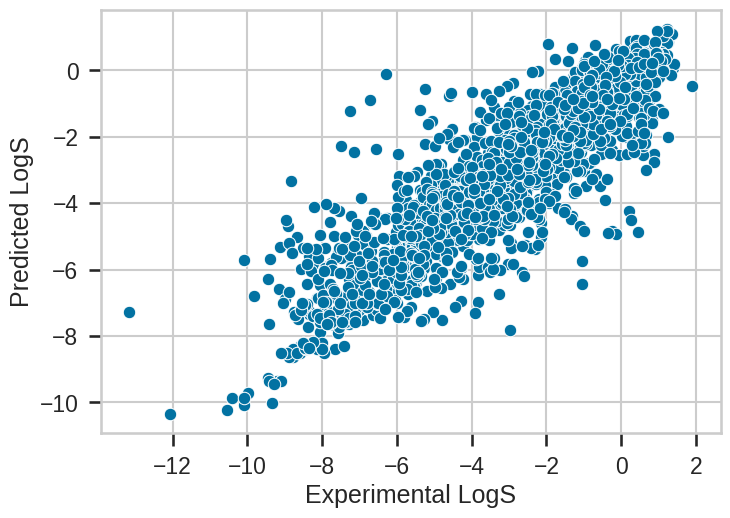

In [13]:
ax = sns.scatterplot(x=test_Y,y=pred)
ax.set(xlabel="Experimental LogS")
ax.set(ylabel="Predicted LogS")

Replot using regplot of seaborn

[Text(0, 0.5, 'Predicted LogS')]

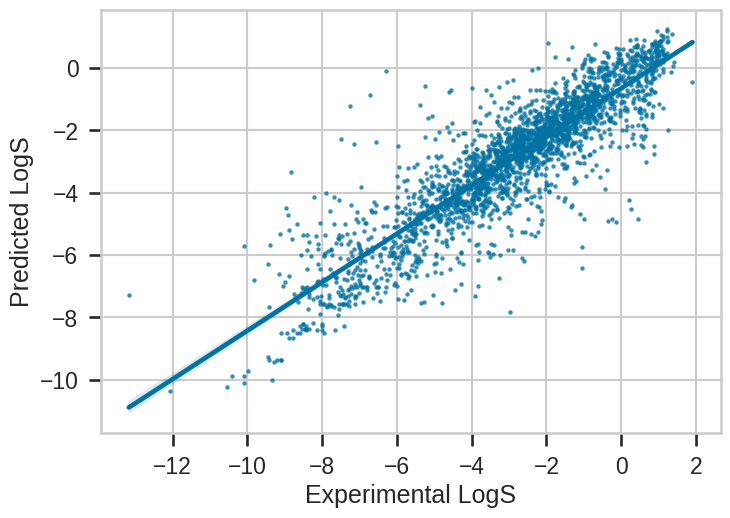

In [14]:
ax = sns.regplot(x=test_Y,y=pred,scatter_kws={'s':10})
ax.set(xlabel="Experimental LogS")
ax.set(ylabel="Predicted LogS")

Calculate R2 and RMSE

In [15]:
r2 = r2_score(test_Y,pred)
mse = mean_squared_error(test_Y,pred)
rmse = np.sqrt(mse)

print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R2 Score: 0.7822
RMSE: 1.1152


Identifying important variables

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

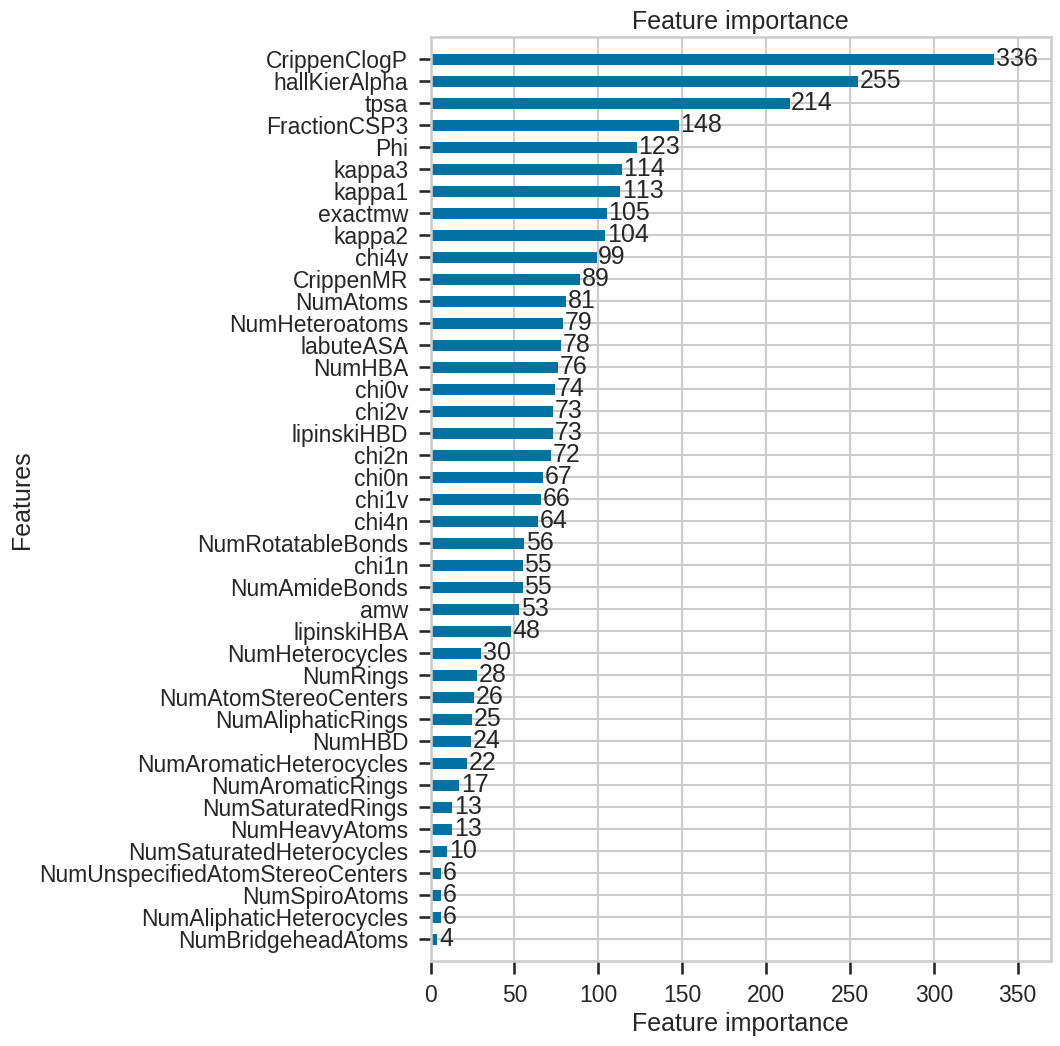

In [16]:
plot_importance(lgbm,figsize=(8,12),height=0.5)

By using Yellowbric library (https://www.scikit-yb.org/en/latest/index.html), we can obtain useful polts for ML models

In [17]:
lgbm = LGBMRegressor()
train, test = train_test_split(sol_df)
train_X = train[property_names]
train_Y = train.LogS
test_X = test[property_names]
test_Y = test.LogS

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6079
[LightGBM] [Info] Number of data points in the train set: 7485, number of used features: 43
[LightGBM] [Info] Start training from score -2.907758


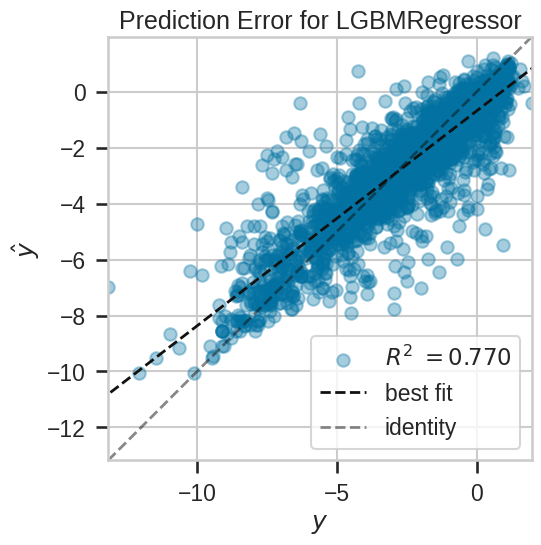

In [18]:
visualizer = prediction_error(lgbm, train_X, train_Y, test_X, test_Y, alpha=0.35)

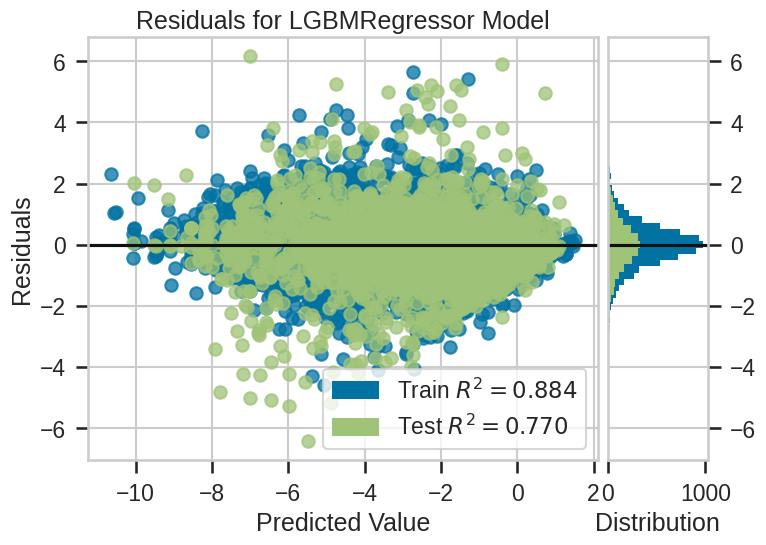

In [19]:
visualizer = ResidualsPlot(lgbm)
visualizer.fit(train_X, train_Y)
visualizer.score(test_X, test_Y)
visualizer.show();

## Ten-fold cross-validation

In [20]:
r2_list = []
for i in tqdm(range(0,10)):
    # setup training and test sets
    train, test = train_test_split(sol_df)
    train_X = train[property_names]
    train_y = train.LogS
    test_X = test[property_names]
    test_y = test.LogS
    # create the regressor
    lgbm = LGBMRegressor()
    # train the model
    lgbm.fit(train_X,train_y)
    pred = lgbm.predict(test_X)
    r2 = r2_score(test_y,pred)
    print(r2)
    r2_list.append(r2)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6084
[LightGBM] [Info] Number of data points in the train set: 7485, number of used features: 43
[LightGBM] [Info] Start training from score -2.913315
0.7588834979514733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6080
[LightGBM] [Info] Number of data points in the train set: 7485, number of used features: 43
[LightGBM] [Info] Start training from score -2.900281
0.7761421151608106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

Plot R2 as a boxplot

[Text(0.5, 0, 'R$^2$')]

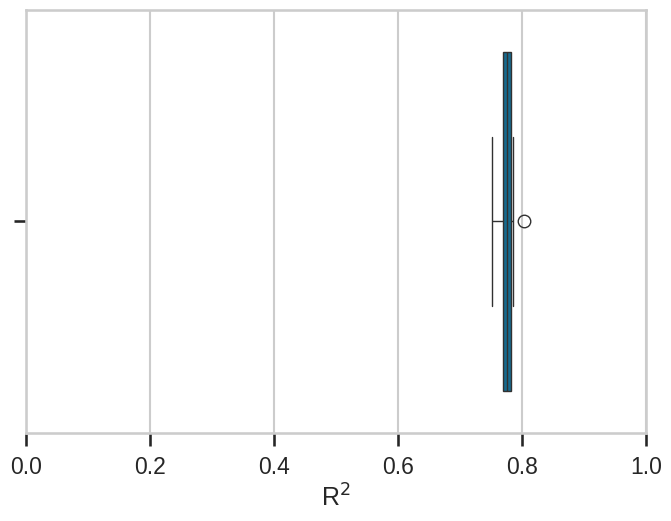

In [21]:
ax = sns.boxplot(x=r2_list)
ax.set(xlim=(0,1))
ax.set(xlabel="R$^2$")